In [102]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.utils import shuffle
from sklearn.model_selection import GridSearchCV
from numpy import absolute
from numpy import mean, std
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

In [103]:
data = pd.read_csv('data.csv')
data.drop(columns=['Unnamed: 0'], inplace= True)

In [3]:
len(data)

209

In [4]:
data.columns

Index(['Date', 'Open', 'High', 'Low', 'Close_x', 'Volume', 'Close_y', 'roe',
       'debtToEquity', 'ev/ebitda', 'eps', 'gdp', 'infl', 'dateStr',
       'reddit_sentiment', 'twitter_sentiment', 'Tweets_Volume',
       'Average_Likes'],
      dtype='object')

### Training Data Preparation

In [104]:
# convert data to training data
def series_to_supervised(data, target, quarterly, n_in=1, n_out=1, dropnan=True):    
    df = data.loc[:, list(pd.Series(data.columns).apply(lambda x: x not in  quarterly)) ].copy()
    n_vars = df.shape[1]
    df_quarterly = data.loc[:, list(pd.Series(data.columns).apply(lambda x: x in  quarterly))].copy()
    
    quarterly_dict= {}
    for col in quarterly:
        quarterly_dict[col] = []
        
    for i in range(len(df_quarterly)):
        for col, arr in quarterly_dict.items():
            temp = 0
            if i < n_in - 1:
                arr.append(None)
            else:
                
                for j in range(n_in):
                    temp += float(df_quarterly.iloc[i - j][col])       
                arr.append(temp / n_in)

    for col in quarterly:
        df_quarterly[col] = quarterly_dict[col]
        
    
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        if i == 1: 
          names += [ df.columns[j] + '(t)' for j in range(n_vars)]
        else:
          names += [ df.columns[j] +('(t-%d)' % (i-1)) for j in range(n_vars)]
    
    cols.append(df_quarterly.shift(n_in))
    names += list(df_quarterly.columns)
    
    
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df[target].shift(-i))
        names += [ target + ('%d(t+%d)' % (1, i+1))]
        

    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

## Feature Importance 

In [6]:
score_df = pd.DataFrame(columns=['vars', 'mae', 'mse', 'rmse'])

### input = 10, ouput = 1

### Time Series Preprocessing

In [7]:
final_data = data.copy().drop(columns=['Date', 'dateStr'])
train_df = series_to_supervised(final_data, 'Close_x',['roe', 'debtToEquity', 'ev/ebitda', 'eps', 'gdp', 'infl'], 10, 1)

In [8]:
train_df

,Open(t-9),High(t-9),Low(t-9),Close_x(t-9),Volume(t-9),Close_y(t-9),reddit_sentiment(t-9),twitter_sentiment(t-9),Tweets_Volume(t-9),Average_Likes(t-9),...,twitter_sentiment(t),Tweets_Volume(t),Average_Likes(t),roe,debtToEquity,ev/ebitda,eps,gdp,infl,Close_x1(t+1)
19,42.570328,43.339757,41.012109,43.286526,485418400.0,2783.300049,0.000000,0.206934,5647.0,0.864530,...,0.357000,5128.0,1.353549,0.109210,2.230663,4.457843,1.050,21013.0850,0.320826,44.470943
20,43.552680,45.582718,43.400244,45.493195,609369200.0,2832.939941,0.000000,0.247462,7051.0,0.985108,...,0.255825,5803.0,0.982940,0.109210,2.230663,4.457843,1.050,21013.0850,0.358173,43.470226
21,45.573048,47.832947,44.697152,45.667412,799875200.0,2798.360107,0.000000,0.230397,7262.0,1.068025,...,0.198488,6714.0,1.111707,0.109210,2.230663,4.457843,1.050,21013.0850,0.395521,42.093044
22,46.373935,46.669125,44.660862,46.272312,607421200.0,2867.189941,0.000000,0.148224,7170.0,1.047978,...,0.159950,5732.0,0.881368,0.109210,2.230663,4.457843,1.050,21013.0850,0.432868,46.775974
23,46.236016,48.447525,46.226340,48.416073,438240400.0,2895.770020,0.000000,0.335615,5978.0,0.961860,...,0.195010,5788.0,1.026780,0.108702,2.241676,4.407096,1.007,21039.0213,0.466752,47.094166
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204,152.912479,158.235520,148.087865,150.290848,485408400.0,3655.040039,0.040667,0.083281,9996.0,5.243998,...,0.043767,9832.0,4.185110,0.408924,5.961537,7.956310,1.200,25723.9410,0.044441,146.406464
205,152.254590,154.228294,137.252417,141.997284,598509300.0,3678.429932,-0.200233,0.066860,10514.0,5.537379,...,0.068209,10923.0,8.523666,0.408924,5.961537,7.956310,1.200,25723.9410,0.067130,144.269730
206,144.569090,147.071107,138.129628,139.973740,396527900.0,3612.389893,0.000000,0.215756,10172.0,3.316654,...,0.222123,9992.0,6.671737,0.420913,5.876639,7.429887,1.209,25765.3461,0.108876,132.168198
207,139.455380,144.060708,133.942956,141.957413,434540300.0,3677.949951,0.055871,0.125320,9963.0,3.595202,...,0.105450,10131.0,3.045109,0.432902,5.791741,6.903465,1.218,25806.7512,0.152985,131.658981


In [9]:
train_df.columns

Index(['Open(t-9)', 'High(t-9)', 'Low(t-9)', 'Close_x(t-9)', 'Volume(t-9)',
       'Close_y(t-9)', 'reddit_sentiment(t-9)', 'twitter_sentiment(t-9)',
       'Tweets_Volume(t-9)', 'Average_Likes(t-9)',
       ...
       'twitter_sentiment(t)', 'Tweets_Volume(t)', 'Average_Likes(t)', 'roe',
       'debtToEquity', 'ev/ebitda', 'eps', 'gdp', 'infl', 'Close_x1(t+1)'],
      dtype='object', length=107)

In [10]:
cols_series = ['Open', 'High', 'Low', 'Close_x', 'Close_y', 'Volume', 'Average_Likes', 'Tweets_Volume','reddit_sentiment', 'twitter_sentiment', ]
cols_unival = ['roe', 'debtToEquity','ev/ebitda', 'eps', 'gdp', 'infl', 'Close_x1(t+1)']

In [11]:
col_order = []
cur = pd.Series(train_df.columns)

for col in cols_series:
    filtered = list(cur[cur.str.startswith(col)])
    if (col == 'Close_x'):
        filtered.remove('Close_x1(t+1)')
    col_order.extend(filtered)

col_order.extend(cols_unival)

In [12]:
col_order

['Open(t-9)',
 'Open(t-8)',
 'Open(t-7)',
 'Open(t-6)',
 'Open(t-5)',
 'Open(t-4)',
 'Open(t-3)',
 'Open(t-2)',
 'Open(t-1)',
 'Open(t)',
 'High(t-9)',
 'High(t-8)',
 'High(t-7)',
 'High(t-6)',
 'High(t-5)',
 'High(t-4)',
 'High(t-3)',
 'High(t-2)',
 'High(t-1)',
 'High(t)',
 'Low(t-9)',
 'Low(t-8)',
 'Low(t-7)',
 'Low(t-6)',
 'Low(t-5)',
 'Low(t-4)',
 'Low(t-3)',
 'Low(t-2)',
 'Low(t-1)',
 'Low(t)',
 'Close_x(t-9)',
 'Close_x(t-8)',
 'Close_x(t-7)',
 'Close_x(t-6)',
 'Close_x(t-5)',
 'Close_x(t-4)',
 'Close_x(t-3)',
 'Close_x(t-2)',
 'Close_x(t-1)',
 'Close_x(t)',
 'Close_y(t-9)',
 'Close_y(t-8)',
 'Close_y(t-7)',
 'Close_y(t-6)',
 'Close_y(t-5)',
 'Close_y(t-4)',
 'Close_y(t-3)',
 'Close_y(t-2)',
 'Close_y(t-1)',
 'Close_y(t)',
 'Volume(t-9)',
 'Volume(t-8)',
 'Volume(t-7)',
 'Volume(t-6)',
 'Volume(t-5)',
 'Volume(t-4)',
 'Volume(t-3)',
 'Volume(t-2)',
 'Volume(t-1)',
 'Volume(t)',
 'Average_Likes(t-9)',
 'Average_Likes(t-8)',
 'Average_Likes(t-7)',
 'Average_Likes(t-6)',
 'Average_

In [13]:
train_df = train_df[col_order]

In [14]:
train_scaled = train_df.copy()
train_scaled = train_scaled.reset_index().drop('index', axis=1)

In [15]:
train_scaled.columns

Index(['Open(t-9)', 'Open(t-8)', 'Open(t-7)', 'Open(t-6)', 'Open(t-5)',
       'Open(t-4)', 'Open(t-3)', 'Open(t-2)', 'Open(t-1)', 'Open(t)',
       ...
       'twitter_sentiment(t-2)', 'twitter_sentiment(t-1)',
       'twitter_sentiment(t)', 'roe', 'debtToEquity', 'ev/ebitda', 'eps',
       'gdp', 'infl', 'Close_x1(t+1)'],
      dtype='object', length=107)

In [16]:
trform_list = {}

In [17]:
def minmaxscaler(index, row, in_size, num_var):
    trform_dict = {}
    trformed_row = []
    value = 0
    for i in range(num_var):
        cur = np.array(row[ i*in_size : (i+1)*in_size ])
        rowmaxmin = cur.max() - cur.min()
        print('rowmaxmin', rowmaxmin)
        rowmin = cur.min()
        print('rowmin', rowmin)
        trform_dict[i] = [rowmaxmin, rowmin]
        trform_list[index] = trform_dict
        cur = [ (x - rowmin) / (rowmaxmin) for x in cur]
        trformed_row.extend(cur)
        if (i == 3):
            target = row[-1]
            value = (target - rowmin) / rowmaxmin
    
    rest = np.array(row[ num_var*in_size : -1 ])
    trformed_row.extend(rest)
    trformed_row.append(value)
    return trformed_row
            

In [18]:
for index, row in train_scaled.iterrows():
    trformed_row = minmaxscaler(index, row, 10, 8)
    train_scaled.loc[index] = trformed_row

rowmaxmin 7.244260366180718
rowmin 42.5703281263114
rowmaxmin 8.756521148131597
rowmin 43.339757078049416
rowmaxmin 7.892715665489575
rowmin 41.01210934001684
rowmaxmin 7.157169342041016
rowmin 43.28652572631836
rowmaxmin 159.72998046875
rowmin 2783.300048828125
rowmaxmin 406921200.0
rowmin 392954000.0
rowmaxmin 1.595535360821513
rowmin 0.864529838852488
rowmaxmin 3013.0
rowmin 4349.0
rowmaxmin 6.261908786413301
rowmin 43.55267970607882
rowmaxmin 6.513559874815776
rowmin 45.58271835136524
rowmaxmin 5.504580859840921
rowmin 43.400244145665496
rowmaxmin 5.972751617431648
rowmin 44.47094345092773
rowmaxmin 144.669921875
rowmin 2798.360107421875
rowmaxmin 406921200.0
rowmin 392954000.0
rowmaxmin 1.4982050457763765
rowmin 0.9618601538976246
rowmaxmin 3013.0
rowmin 4349.0
rowmaxmin 4.826292626252268
rowmin 44.98829586623985
rowmaxmin 6.4327453079676715
rowmin 45.66353291821334
rowmaxmin 5.716353320909185
rowmin 43.18847168459723
rowmaxmin 6.973468780517578
rowmin 43.4702262878418
rowmaxmin 1

rowmin 3910.0
rowmaxmin 8.421688937892952
rowmin 70.90121279022786
rowmaxmin 6.699736438801239
rowmin 73.51052162900112
rowmaxmin 15.281185374208107
rowmin 62.84304470962665
rowmaxmin 14.408523559570312
rowmin 65.24530029296875
rowmaxmin 633.599853515625
rowmin 2746.56005859375
rowmaxmin 1134326400.0
rowmin 382914800.0
rowmaxmin 2.5424681072823816
rowmin 1.1605166051660516
rowmaxmin 2634.0
rowmin 5608.0
rowmaxmin 11.388576933948372
rowmin 67.93432479417244
rowmaxmin 9.996261057725519
rowmin 70.21399701007684
rowmaxmin 19.2939021310708
rowmin 58.83032795276396
rowmaxmin 20.28176498413086
rowmin 59.3720588684082
rowmaxmin 994.030029296875
rowmin 2386.1298828125
rowmaxmin 1269603600.0
rowmin 382914800.0
rowmaxmin 2.5424681072823816
rowmin 1.1605166051660516
rowmaxmin 2634.0
rowmin 5608.0
rowmaxmin 18.651668905370784
rowmin 60.67123282275003
rowmaxmin 17.063250893923552
rowmin 63.147007173878805
rowmaxmin 26.007906970590128
rowmin 52.11632311324463
rowmaxmin 24.654815673828125
rowmin 54.99

rowmaxmin 2.6439464667505197
rowmin 2.099093745357302
rowmaxmin 3902.0
rowmin 4526.0
rowmaxmin 15.374813853185643
rowmin 108.00766954937647
rowmaxmin 8.753379702778062
rowmin 115.5128728742382
rowmaxmin 12.840846672302476
rowmin 105.70294688474958
rowmaxmin 15.394485473632798
rowmin 107.13109588623048
rowmaxmin 381.719970703125
rowmin 3310.239990234375
rowmaxmin 355159900.0
rowmin 406474900.0
rowmaxmin 2.550865100077487
rowmin 2.1921751120303345
rowmaxmin 3902.0
rowmin 4526.0
rowmaxmin 15.374813853185643
rowmin 108.00766954937647
rowmaxmin 12.334855809405596
rowmin 115.5128728742382
rowmaxmin 16.096725077078347
rowmin 105.70294688474958
rowmaxmin 19.38467407226561
rowmin 107.13109588623048
rowmaxmin 384.679931640625
rowmin 3310.239990234375
rowmaxmin 355159900.0
rowmin 406474900.0
rowmaxmin 2.550865100077487
rowmin 2.1921751120303345
rowmaxmin 3871.0
rowmin 4526.0
rowmaxmin 21.842940580533437
rowmin 108.00766954937647
rowmaxmin 19.99113318160566
rowmin 115.5128728742382
rowmaxmin 22.21

rowmaxmin 11.175707144105218
rowmin 122.23835765058143
rowmaxmin 10.41011918536914
rowmin 125.02956107684425
rowmaxmin 9.27425783699941
rowmin 121.00112730998852
rowmaxmin 10.06607818603517
rowmin 123.33702850341795
rowmaxmin 127.31982421875
rowmin 4163.2900390625
rowmaxmin 215329400.0
rowmin 294522100.0
rowmaxmin 3.7083415026559265
rowmin 2.8613739922888186
rowmaxmin 3784.0
rowmin 4738.0
rowmaxmin 11.184579014876789
rowmin 122.23835765058143
rowmaxmin 13.540251313976555
rowmin 125.02956107684425
rowmaxmin 11.97640940765281
rowmin 121.00112730998852
rowmaxmin 15.193199157714858
rowmin 123.33702850341795
rowmaxmin 189.0498046875
rowmin 4163.2900390625
rowmaxmin 250695600.0
rowmin 259155900.0
rowmaxmin 3.7083415026559265
rowmin 2.8613739922888186
rowmaxmin 3784.0
rowmin 4738.0
rowmaxmin 16.400739290083152
rowmin 122.23835765058143
rowmaxmin 19.795687863323607
rowmin 125.02956107684425
rowmaxmin 17.637969630676068
rowmin 121.00112730998852
rowmaxmin 19.68680572509767
rowmin 123.3370285034

rowmaxmin 21.708492508672805
rowmin 149.19621570320402
rowmaxmin 27.652496337890625
rowmin 149.71307373046875
rowmaxmin 409.5302734375
rowmin 4173.10986328125
rowmaxmin 257580600.0
rowmin 276066800.0
rowmaxmin 4.043330198490099
rowmin 4.226236057932412
rowmaxmin 2491.0
rowmin 5998.0
rowmaxmin 26.43982544556127
rowmin 149.99139258232748
rowmaxmin 16.102453008989983
rowmin 162.4260703735068
rowmaxmin 21.708492508672805
rowmin 149.19621570320402
rowmaxmin 27.652496337890625
rowmin 149.71307373046875
rowmaxmin 409.5302734375
rowmin 4173.10986328125
rowmaxmin 257580600.0
rowmin 276066800.0
rowmaxmin 2.3368203218895465
rowmin 4.226236057932412
rowmaxmin 2737.0
rowmin 5752.0
rowmaxmin 26.43982544556127
rowmin 149.99139258232748
rowmaxmin 16.102453008989983
rowmin 162.4260703735068
rowmaxmin 21.708492508672805
rowmin 149.19621570320402
rowmaxmin 27.652496337890625
rowmin 149.71307373046875
rowmaxmin 409.5302734375
rowmin 4173.10986328125
rowmaxmin 257580600.0
rowmin 276066800.0
rowmaxmin 2.968

In [19]:
trform_list

{0: {0: [7.244260366180718, 42.5703281263114],
  1: [8.756521148131597, 43.339757078049416],
  2: [7.892715665489575, 41.01210934001684],
  3: [7.157169342041016, 43.28652572631836],
  4: [159.72998046875, 2783.300048828125],
  5: [406921200.0, 392954000.0],
  6: [1.595535360821513, 0.864529838852488],
  7: [3013.0, 4349.0]},
 1: {0: [6.261908786413301, 43.55267970607882],
  1: [6.513559874815776, 45.58271835136524],
  2: [5.504580859840921, 43.400244145665496],
  3: [5.972751617431648, 44.47094345092773],
  4: [144.669921875, 2798.360107421875],
  5: [406921200.0, 392954000.0],
  6: [1.4982050457763765, 0.9618601538976246],
  7: [3013.0, 4349.0]},
 2: {0: [4.826292626252268, 44.98829586623985],
  1: [6.4327453079676715, 45.66353291821334],
  2: [5.716353320909185, 43.18847168459723],
  3: [6.973468780517578, 43.4702262878418],
  4: [144.669921875, 2798.360107421875],
  5: [406921200.0, 392954000.0],
  6: [1.4982050457763765, 0.9618601538976246],
  7: [3013.0, 4349.0]},
 3: {0: [6.3564

In [20]:
train_scaled.columns

Index(['Open(t-9)', 'Open(t-8)', 'Open(t-7)', 'Open(t-6)', 'Open(t-5)',
       'Open(t-4)', 'Open(t-3)', 'Open(t-2)', 'Open(t-1)', 'Open(t)',
       ...
       'twitter_sentiment(t-2)', 'twitter_sentiment(t-1)',
       'twitter_sentiment(t)', 'roe', 'debtToEquity', 'ev/ebitda', 'eps',
       'gdp', 'infl', 'Close_x1(t+1)'],
      dtype='object', length=107)

In [21]:
train_scaled

,Open(t-9),Open(t-8),Open(t-7),Open(t-6),Open(t-5),Open(t-4),Open(t-3),Open(t-2),Open(t-1),Open(t),...,twitter_sentiment(t-2),twitter_sentiment(t-1),twitter_sentiment(t),roe,debtToEquity,ev/ebitda,eps,gdp,infl,Close_x1(t+1)
0,0.000000,0.135604,0.414496,0.525051,0.506013,0.814297,0.785572,0.951570,0.905813,1.000000,...,0.296578,0.235196,0.357000,0.109210,2.230663,4.457843,1.050,21013.0850,0.320826,0.165487
1,0.000000,0.322644,0.450542,0.428517,0.785164,0.751933,0.943973,0.891038,1.000000,0.275421,...,0.235196,0.357000,0.255825,0.109210,2.230663,4.457843,1.050,21013.0850,0.358173,-0.167547
2,0.121160,0.287102,0.258526,0.721259,0.678144,0.927307,0.858626,1.000000,0.059890,0.000000,...,0.357000,0.255825,0.198488,0.109210,2.230663,4.457843,1.050,21013.0850,0.395521,-0.197489
3,0.458719,0.437021,0.788361,0.755625,0.944806,0.892659,1.000000,0.286204,0.240731,0.000000,...,0.255825,0.198488,0.159950,0.109210,2.230663,4.457843,1.050,21013.0850,0.432868,0.560786
4,0.503098,0.813201,0.784307,0.951284,0.905258,1.000000,0.369982,0.329846,0.117370,0.000000,...,0.198488,0.159950,0.195010,0.108702,2.241676,4.407096,1.007,21039.0213,0.466752,0.598890
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
185,0.889329,0.845851,0.337946,0.000000,0.368248,0.671279,1.000000,0.048941,0.828229,0.558349,...,0.093421,0.091963,0.043767,0.408924,5.961537,7.956310,1.200,25723.9410,0.044441,0.551543
186,0.845851,0.337946,0.000000,0.368248,0.671279,1.000000,0.048941,0.828229,0.558349,0.304964,...,0.091963,0.043767,0.068209,0.408924,5.961537,7.956310,1.200,25723.9410,0.067130,0.402892
187,0.337946,0.000000,0.368248,0.671279,1.000000,0.048941,0.828229,0.558349,0.304964,0.488405,...,0.043767,0.068209,0.222123,0.420913,5.876639,7.429887,1.209,25765.3461,0.108876,-0.439001
188,0.000000,0.368248,0.671279,1.000000,0.048941,0.828229,0.558349,0.304964,0.488405,0.648749,...,0.068209,0.222123,0.105450,0.432902,5.791741,6.903465,1.218,25806.7512,0.152985,-0.024618


### Coefficient as Feature Importance

In [22]:
x = train_scaled.drop('Close_x1(t+1)', axis=1)
y = train_scaled['Close_x1(t+1)']

In [23]:
# Take last 50 days as test data
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=88, shuffle=False)

In [24]:
X_train, y_train = shuffle(X_train, y_train, random_state=0)

In [25]:
from sklearn.linear_model import LinearRegression

best_model = LinearRegression().fit(X_train, y_train)

In [26]:
pred = best_model.predict(X_test)
pred_trformed = [pred[x - y_test.index[0]] * trform_list[x][3][0] + trform_list[x][3][1] for x in y_test.index]
y_trformed =  [y[x] * trform_list[x][3][0] + trform_list[x][3][1] for x in y_test.index]

mae = mean_absolute_error(y_trformed, pred_trformed)
mse = mean_squared_error(y_trformed, pred_trformed)
rmse = mean_squared_error(y_trformed, pred_trformed, squared=False)
r2 = r2_score(y_trformed, pred_trformed)
score_df.loc[len(score_df)] = ['past10_LR', mae, mse, rmse]
    
print('Mean Absolute Error:', mae)
print('Mean Squared Error:', mse)
print('Root Mean Squared Error:', rmse)
print('R-squared:', r2)    

Mean Absolute Error: 12.611757422316723
Mean Squared Error: 253.10541922548268
Root Mean Squared Error: 15.909287200421101
R-squared: -0.6615660436843998


<AxesSubplot:>

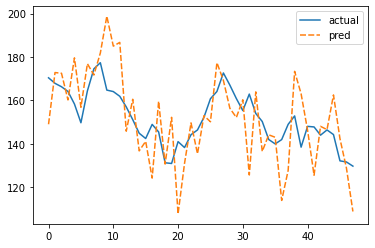

In [27]:
output = pd.DataFrame({'actual': np.array(y_trformed), 'pred': np.array(pred_trformed)})

sns.lineplot(data=output)

Feature: Open(t-9), Score: -0.0620599791
Feature: Open(t-8), Score: 0.7009631512
Feature: Open(t-7), Score: -0.3183856867
Feature: Open(t-6), Score: 1.3755103095
Feature: Open(t-5), Score: -1.6669001935
Feature: Open(t-4), Score: 0.4716912092
Feature: Open(t-3), Score: 0.0873758274
Feature: Open(t-2), Score: -0.1922089259
Feature: Open(t-1), Score: -0.1991785944
Feature: Open(t), Score: 0.0155784302
Feature: High(t-9), Score: 0.1389716987
Feature: High(t-8), Score: 0.1938449890
Feature: High(t-7), Score: -0.2909838998
Feature: High(t-6), Score: -0.4683153411
Feature: High(t-5), Score: -0.1071265865
Feature: High(t-4), Score: -0.0911300589
Feature: High(t-3), Score: -0.2440326472
Feature: High(t-2), Score: 0.1097126449
Feature: High(t-1), Score: -0.1517390339
Feature: High(t), Score: -0.1819124242
Feature: Low(t-9), Score: -0.2009057389
Feature: Low(t-8), Score: 0.0053857334
Feature: Low(t-7), Score: 0.2077654744
Feature: Low(t-6), Score: 0.4931179432
Feature: Low(t-5), Score: 0.2910158

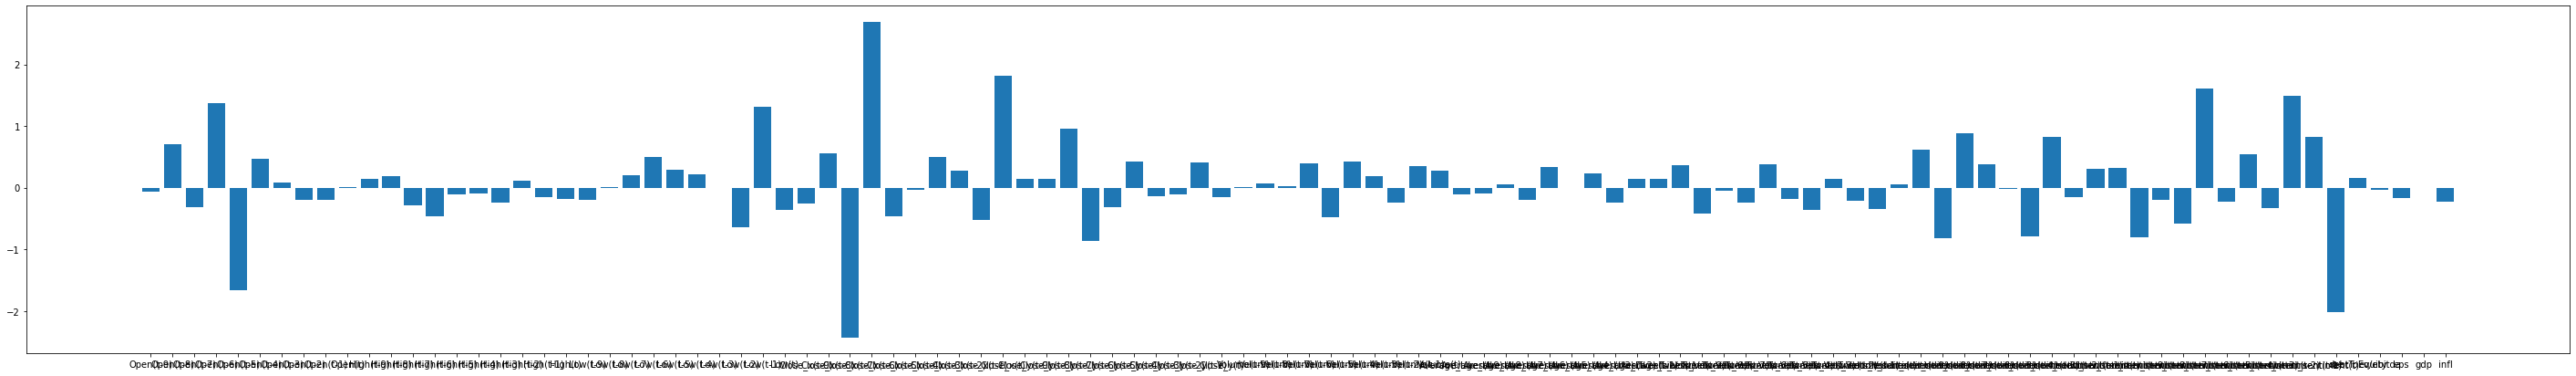

In [28]:
# get importance
importance = best_model.coef_
# summarize feature importance
for i,v in enumerate(importance):
 print(f'Feature: {col_order[i]}, Score: {v:.10f}')
# plot feature importance
fig = plt.figure(figsize=(50,7))
plt.bar([col_order[x] for x in range(len(importance))], importance)
plt.show()

### Input : 5 Output : 1

### Coefficient as Feature Importance

In [29]:
final_data = data.copy().drop(columns=['Date', 'dateStr'])
train_df = series_to_supervised(final_data, 'Close_x',['roe', 'debtToEquity', 'ev/ebitda', 'eps', 'gdp', 'infl'], 5, 1)

In [30]:
cols_series = ['Open', 'High', 'Low', 'Close_x', 'Close_y', 'Volume','Average_Likes', 'Tweets_Volume', 'reddit_sentiment', 'twitter_sentiment']
cols_unival = ['roe', 'debtToEquity','ev/ebitda', 'eps', 'gdp', 'infl', 'Close_x1(t+1)']

In [31]:
col_order = []
cur = pd.Series(train_df.columns)

for col in cols_series:
    filtered = list(cur[cur.str.startswith(col)])
    if (col == 'Close_x'):
        filtered.remove('Close_x1(t+1)')
    col_order.extend(filtered)

col_order.extend(cols_unival)

In [32]:
train_df = train_df[col_order]

In [33]:
train_df.iloc[150]

Open(t-4)                 1.739731e+02
Open(t-3)                 1.703100e+02
Open(t-2)                 1.788473e+02
Open(t-1)                 1.812994e+02
Open(t)                   1.710645e+02
High(t-4)                 1.798202e+02
High(t-3)                 1.791055e+02
High(t-2)                 1.815475e+02
High(t-1)                 1.816071e+02
High(t)                   1.758891e+02
Low(t-4)                  1.662399e+02
Low(t-3)                  1.678878e+02
Low(t-2)                  1.759685e+02
Low(t-1)                  1.669447e+02
Low(t)                    1.695754e+02
Close_x(t-4)              1.685132e+02
Close_x(t-3)              1.790161e+02
Close_x(t-2)              1.806839e+02
Close_x(t-1)              1.709354e+02
Close_x(t)                1.718090e+02
Close_y(t-4)              4.568020e+03
Close_y(t-3)              4.791190e+03
Close_y(t-2)              4.796560e+03
Close_y(t-1)              4.670290e+03
Close_y(t)                4.662850e+03
Volume(t-4)              

In [34]:
train_scaled = train_df.copy()
train_scaled = train_scaled.reset_index().drop('index', axis=1)

In [35]:
trform_list = {}

In [36]:
for index, row in train_scaled.iterrows():
    trformed_row = minmaxscaler(index, row, 5, 8)
    train_scaled.loc[index] = trformed_row

rowmaxmin 4.386064828000329
rowmin 37.64469954219178
rowmaxmin 1.65090734192961
rowmin 41.35737127213854
rowmaxmin 4.66452364174642
rowmin 37.129117884311526
rowmaxmin 1.72845458984375
rowmin 40.82010269165039
rowmaxmin 86.31005859375
rowmin 2709.800048828125
rowmaxmin 465456000.0
rowmin 364944800.0
rowmaxmin 1.5851742151109245
rowmin 1.0555014605647517
rowmaxmin 2621.0
rowmin 4779.0
rowmaxmin 1.5074074219748042
rowmin 41.0629207043366
rowmaxmin 1.6066107300115746
rowmin 41.73314634803784
rowmaxmin 1.2168728441418253
rowmin 40.57676868191612
rowmaxmin 2.4664230346679688
rowmin 40.82010269165039
rowmaxmin 86.31005859375
rowmin 2709.800048828125
rowmaxmin 198640400.0
rowmin 364944800.0
rowmaxmin 0.24155930113495705
rowmin 0.864529838852488
rowmaxmin 868.0
rowmin 4779.0
rowmaxmin 2.4897590017422218
rowmin 41.0629207043366
rowmaxmin 3.8495720033273955
rowmin 41.73314634803784
rowmaxmin 2.417169543947253
rowmin 40.98307460171824
rowmaxmin 4.25848388671875
rowmin 41.234710693359375
rowmaxmin

rowmaxmin 1.9907198282575427
rowmin 1.7122648841908907
rowmaxmin 2466.0
rowmin 5776.0
rowmaxmin 4.242866318039233
rowmin 73.32467274996104
rowmaxmin 2.63620252901201
rowmin 77.53820307440458
rowmaxmin 4.027674711056022
rowmin 72.66929125208206
rowmaxmin 3.1521987915039062
rowmin 75.4815673828125
rowmaxmin 108.460205078125
rowmin 3243.6298828125
rowmaxmin 348059600.0
rowmin 530523600.0
rowmaxmin 2.019339056571091
rowmin 1.6836456558773425
rowmaxmin 2372.0
rowmin 5870.0
rowmaxmin 2.8778225321774613
rowmin 76.44507919594335
rowmaxmin 2.263664850466597
rowmin 77.94659321733576
rowmaxmin 4.217539498984777
rowmin 73.90669058484998
rowmaxmin 4.1722564697265625
rowmin 75.4815673828125
rowmaxmin 136.530029296875
rowmin 3243.6298828125
rowmaxmin 495668400.0
rowmin 382914800.0
rowmaxmin 2.019339056571091
rowmin 1.6836456558773425
rowmaxmin 2634.0
rowmin 5608.0
rowmaxmin 2.8778225321774613
rowmin 76.44507919594335
rowmaxmin 1.141210581246824
rowmin 79.06904748655553
rowmaxmin 7.2263324633074575
ro

rowmaxmin 1.2086981131549375
rowmin 2.962662662662663
rowmaxmin 2076.0
rowmin 8563.0
rowmaxmin 23.464930672012343
rowmin 107.29467926894895
rowmaxmin 23.415196415825193
rowmin 112.48576145939904
rowmaxmin 14.6361789711478
rowmin 106.56222256748484
rowmaxmin 16.26654052734375
rowmin 110.82913970947266
rowmaxmin 139.840087890625
rowmin 3360.469970703125
rowmaxmin 213362000.0
rowmin 848709200.0
rowmaxmin 1.0679319319319318
rowmin 2.962662662662663
rowmaxmin 2076.0
rowmin 8563.0
rowmaxmin 20.476728015165676
rowmin 110.28288192579562
rowmaxmin 21.562616495694442
rowmin 114.3383413795298
rowmaxmin 13.73489161094028
rowmin 107.46350992769236
rowmaxmin 14.215042114257812
rowmin 112.8806381225586
rowmaxmin 118.320068359375
rowmin 3381.989990234375
rowmaxmin 213362000.0
rowmin 848709200.0
rowmaxmin 1.0679319319319318
rowmin 2.962662662662663
rowmaxmin 1516.0
rowmin 9123.0
rowmaxmin 18.526572496792454
rowmin 112.23303744416884
rowmaxmin 18.86143527160972
rowmin 117.03952260361451
rowmaxmin 19.651

rowmin 122.76228273792562
rowmaxmin 12.647761053533571
rowmin 117.44627523765826
rowmaxmin 13.290023803710938
rowmin 119.94618225097656
rowmaxmin 222.669677734375
rowmin 3940.590087890625
rowmaxmin 278116000.0
rowmin 367736000.0
rowmaxmin 0.8182076413931298
rowmin 3.5740344876727947
rowmaxmin 1944.0
rowmin 5073.0
rowmaxmin 14.732657104620458
rowmin 118.6814076900662
rowmaxmin 11.155710645317768
rowmin 122.76228273792562
rowmaxmin 12.647761053533571
rowmin 117.44627523765826
rowmaxmin 13.290023803710938
rowmin 119.94618225097656
rowmaxmin 216.530029296875
rowmin 3971.090087890625
rowmaxmin 89996700.0
rowmin 367736000.0
rowmaxmin 0.8182076413931298
rowmin 3.5740344876727947
rowmaxmin 1944.0
rowmin 5073.0
rowmaxmin 14.732657104620458
rowmin 118.6814076900662
rowmaxmin 10.780228487032673
rowmin 124.65945177518071
rowmaxmin 12.647761053533571
rowmin 117.44627523765826
rowmaxmin 8.833663940429702
rowmin 124.4025421142578
rowmaxmin 114.750244140625
rowmin 4077.909912109375
rowmaxmin 142115500

rowmaxmin 13.06414794921875
rowmin 160.44241333007812
rowmaxmin 261.18017578125
rowmin 4401.669921875
rowmaxmin 325615500.0
rowmin 315890100.0
rowmaxmin 3.7288645506951497
rowmin 4.540701705727361
rowmaxmin 2319.0
rowmin 7211.0
rowmaxmin 14.920479093370687
rowmin 157.82167618455216
rowmaxmin 4.303485142551693
rowmin 171.28284714221417
rowmaxmin 15.863580826297152
rowmin 153.5728350600115
rowmaxmin 13.06414794921875
rowmin 160.44241333007812
rowmaxmin 166.6796875
rowmin 4348.8701171875
rowmaxmin 365438800.0
rowmin 276066800.0
rowmaxmin 3.762897366792634
rowmin 4.506668889629877
rowmaxmin 3532.0
rowmin 5998.0
rowmaxmin 14.920479093370687
rowmin 157.82167618455216
rowmaxmin 9.90000005621701
rowmin 165.68633222854885
rowmaxmin 18.351634976355484
rowmin 151.08478090995317
rowmaxmin 9.380783081054688
rowmin 164.1257781982422
rowmaxmin 166.6796875
rowmin 4348.8701171875
rowmaxmin 365438800.0
rowmin 276066800.0
rowmaxmin 3.762897366792634
rowmin 4.506668889629877
rowmaxmin 3532.0
rowmin 5998.0

In [37]:
train_scaled.iloc[150]

Open(t-4)                     0.333333
Open(t-3)                     0.000000
Open(t-2)                     0.776873
Open(t-1)                     1.000000
Open(t)                       0.068657
High(t-4)                     0.687499
High(t-3)                     0.562498
High(t-2)                     0.989581
High(t-1)                     1.000000
High(t)                       0.000000
Low(t-4)                      0.000000
Low(t-3)                      0.169387
Low(t-2)                      1.000000
Low(t-1)                      0.072448
Low(t)                        0.342860
Close_x(t-4)                  0.000000
Close_x(t-3)                  0.862970
Close_x(t-2)                  1.000000
Close_x(t-1)                  0.199022
Close_x(t)                    0.270802
Close_y(t-4)                  0.000000
Close_y(t-3)                  0.976503
Close_y(t-2)                  1.000000
Close_y(t-1)                  0.447493
Close_y(t)                    0.414939
Volume(t-4)              

In [38]:
x = train_scaled.drop('Close_x1(t+1)', axis=1)
y = train_scaled['Close_x1(t+1)']

In [39]:
X_train.index.max()

141

In [40]:
X_test.index.min()

142

In [41]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=88, shuffle=False)

In [42]:
X_train, y_train = shuffle(X_train, y_train, random_state=0)

In [43]:
from sklearn.linear_model import LinearRegression

best_model = LinearRegression().fit(X_train, y_train)

In [44]:
pred = best_model.predict(X_test)
pred_trformed = [pred[x - y_test.index[0]] * trform_list[x][3][0] + trform_list[x][3][1] for x in y_test.index]
y_trformed =  [y[x] * trform_list[x][3][0] + trform_list[x][3][1] for x in y_test.index]

mae = mean_absolute_error(y_trformed, pred_trformed)
mse = mean_squared_error(y_trformed, pred_trformed)
rmse = mean_squared_error(y_trformed, pred_trformed, squared=False)
r2 = r2_score(y_trformed, pred_trformed)
score_df.loc[len(score_df)] = ['past5_LR', mae, mse, rmse]
    
print('Mean Absolute Error:', mae)
print('Mean Squared Error:', mse)
print('Root Mean Squared Error:', rmse)
print('R-squared:', r2)    

Mean Absolute Error: 7.9903220006252536
Mean Squared Error: 88.8825836315452
Root Mean Squared Error: 9.4277560231237
R-squared: 0.43239891769872985


<AxesSubplot:>

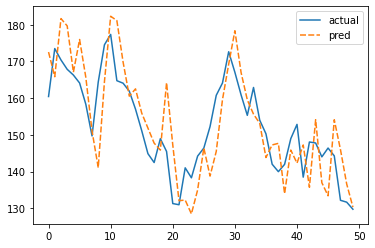

In [45]:
output = pd.DataFrame({'actual': np.array(y_trformed), 'pred': np.array(pred_trformed)})

sns.lineplot(data=output)

Feature: Open(t-4), Score: 0.3348178363
Feature: Open(t-3), Score: -0.0862234314
Feature: Open(t-2), Score: 0.1398788451
Feature: Open(t-1), Score: -0.2998988936
Feature: Open(t), Score: 0.2945177799
Feature: High(t-4), Score: -0.3458561939
Feature: High(t-3), Score: -0.3803915982
Feature: High(t-2), Score: -0.0700436547
Feature: High(t-1), Score: 0.0784257169
Feature: High(t), Score: -0.5963040285
Feature: Low(t-4), Score: -0.3426061506
Feature: Low(t-3), Score: 0.3272904834
Feature: Low(t-2), Score: 0.3521605991
Feature: Low(t-1), Score: 0.0938672703
Feature: Low(t), Score: -0.5568857507
Feature: Close_x(t-4), Score: -0.1604377415
Feature: Close_x(t-3), Score: 0.0977949209
Feature: Close_x(t-2), Score: 0.0046616498
Feature: Close_x(t-1), Score: -0.0070918945
Feature: Close_x(t), Score: 1.6599415542
Feature: Close_y(t-4), Score: 0.5508178560
Feature: Close_y(t-3), Score: -0.1443798951
Feature: Close_y(t-2), Score: 0.1948686167
Feature: Close_y(t-1), Score: 0.0916094985
Feature: Close_

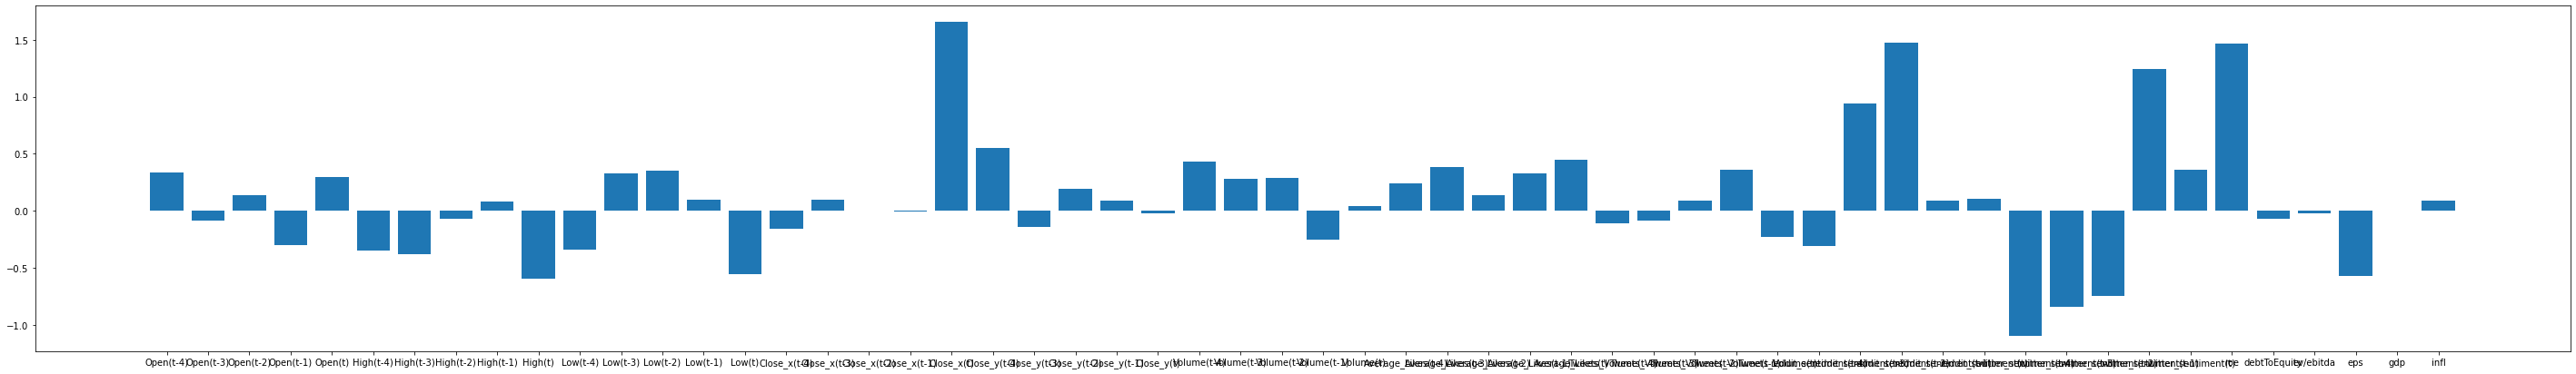

In [46]:
# get importance
importance = best_model.coef_
# summarize feature importance
for i,v in enumerate(importance):
 print(f'Feature: {col_order[i]}, Score: {v:.10f}')
# plot feature importance
fig = plt.figure(figsize=(50,7))
plt.bar([col_order[x] for x in range(len(importance))], importance)
plt.show()

Feature: Open, Score: 0.3830921362
Feature: High, Score: -1.3141697583
Feature: Low, Score: -0.1261735484
Feature: Close_x, Score: 1.5948684888
Feature: Close_y, Score: 0.6724974446
Feature: Volume, Score: 0.7822367660
Feature: Average_Likes, Score: 1.5475267825
Feature: Tweets_Volume, Score: 0.0256932935
Feature: reddit_sentiment, Score: 2.3025894978
Feature: twitter_sentiment, Score: -1.0826820296
Feature: roe, Score: 1.4633314927
Feature: debtToEquity, Score: -0.0742168591
Feature: ev/ebitda, Score: -0.0263556637
Feature: eps, Score: -0.5684744062
Feature: gdp, Score: -0.0000689266
Feature: infl, Score: 0.0896620113


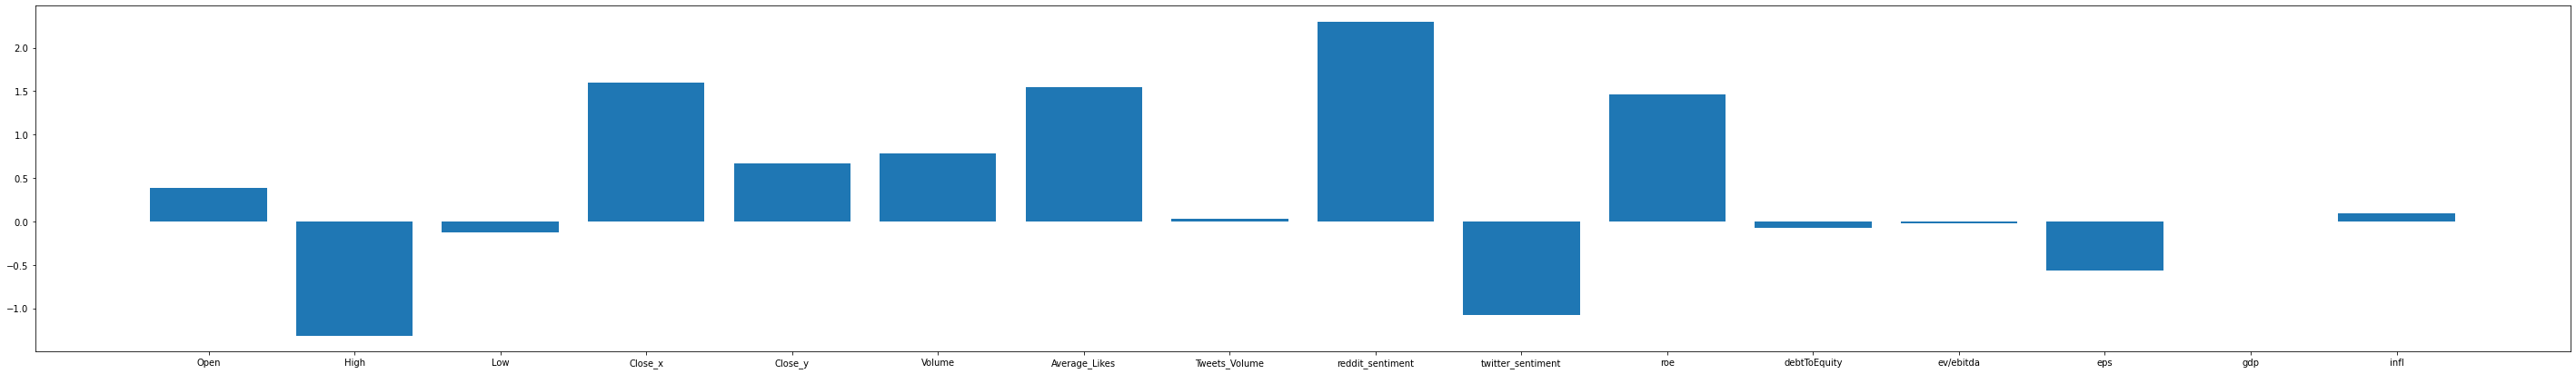

In [47]:
# get importance
importance = best_model.coef_

cols = ['Open', 'High', 'Low', 'Close_x', 'Close_y', 'Volume', 'Average_Likes', 'Tweets_Volume','reddit_sentiment', 'twitter_sentiment','roe', 'debtToEquity','ev/ebitda', 'eps', 'gdp', 'infl']

agg_impt = []
cur = 0
cur_var = 'Open'
at = 0
for i,v in enumerate(importance):
    if (col_order[i].find(cur_var) > -1):
        cur += v
    else: 
        agg_impt.append(cur)
        print(f'Feature: {cols[at]}, Score: {cur:.10f}')
        at += 1
        cur_var = cols[at]
        cur = v
agg_impt.append(cur)
print(f'Feature: {cols[-1]}, Score: {cur:.10f}')
 
# plot feature importance
fig = plt.figure(figsize=(50,7))
plt.bar([cols[x] for x in range(len(cols))], agg_impt)
plt.show()

### Random Forest Feature Importance

In [48]:
from sklearn.ensemble import RandomForestRegressor

best_model = RandomForestRegressor()
best_model.fit(X_train, y_train)

RandomForestRegressor()

In [49]:
pred = best_model.predict(X_test)
pred_trformed = [pred[x - y_test.index[0]] * trform_list[x][3][0] + trform_list[x][3][1] for x in y_test.index]
y_trformed =  [y[x] * trform_list[x][3][0] + trform_list[x][3][1] for x in y_test.index]

mae = mean_absolute_error(y_trformed, pred_trformed)
mse = mean_squared_error(y_trformed, pred_trformed)
rmse = mean_squared_error(y_trformed, pred_trformed, squared=False)
r2 = r2_score(y_trformed, pred_trformed)
score_df.loc[len(score_df)] = ['past5_RF', mae, mse, rmse]
    
print('Mean Absolute Error:', mae)
print('Mean Squared Error:', mse)
print('Root Mean Squared Error:', rmse)
print('R-squared:', r2)    

Mean Absolute Error: 7.440568635571819
Mean Squared Error: 79.04374381688973
Root Mean Squared Error: 8.89065485872046
R-squared: 0.4952294059588086


<AxesSubplot:>

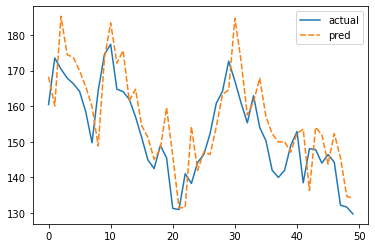

In [50]:
output = pd.DataFrame({'actual': np.array(y_trformed), 'pred': np.array(pred_trformed)})

sns.lineplot(data=output)

Feature: Open(t-4), Score: 0.0010433858
Feature: Open(t-3), Score: 0.0032633992
Feature: Open(t-2), Score: 0.0088430004
Feature: Open(t-1), Score: 0.0148386461
Feature: Open(t), Score: 0.0034297033
Feature: High(t-4), Score: 0.0025422755
Feature: High(t-3), Score: 0.0090298474
Feature: High(t-2), Score: 0.0172470896
Feature: High(t-1), Score: 0.0062202730
Feature: High(t), Score: 0.0036433099
Feature: Low(t-4), Score: 0.0036123973
Feature: Low(t-3), Score: 0.0091426008
Feature: Low(t-2), Score: 0.0047223876
Feature: Low(t-1), Score: 0.0053689130
Feature: Low(t), Score: 0.0605675478
Feature: Close_x(t-4), Score: 0.0142988244
Feature: Close_x(t-3), Score: 0.0187240391
Feature: Close_x(t-2), Score: 0.0105926537
Feature: Close_x(t-1), Score: 0.0082477896
Feature: Close_x(t), Score: 0.3544888124
Feature: Close_y(t-4), Score: 0.0036165301
Feature: Close_y(t-3), Score: 0.0048968804
Feature: Close_y(t-2), Score: 0.0151487360
Feature: Close_y(t-1), Score: 0.0050872929
Feature: Close_y(t), Score

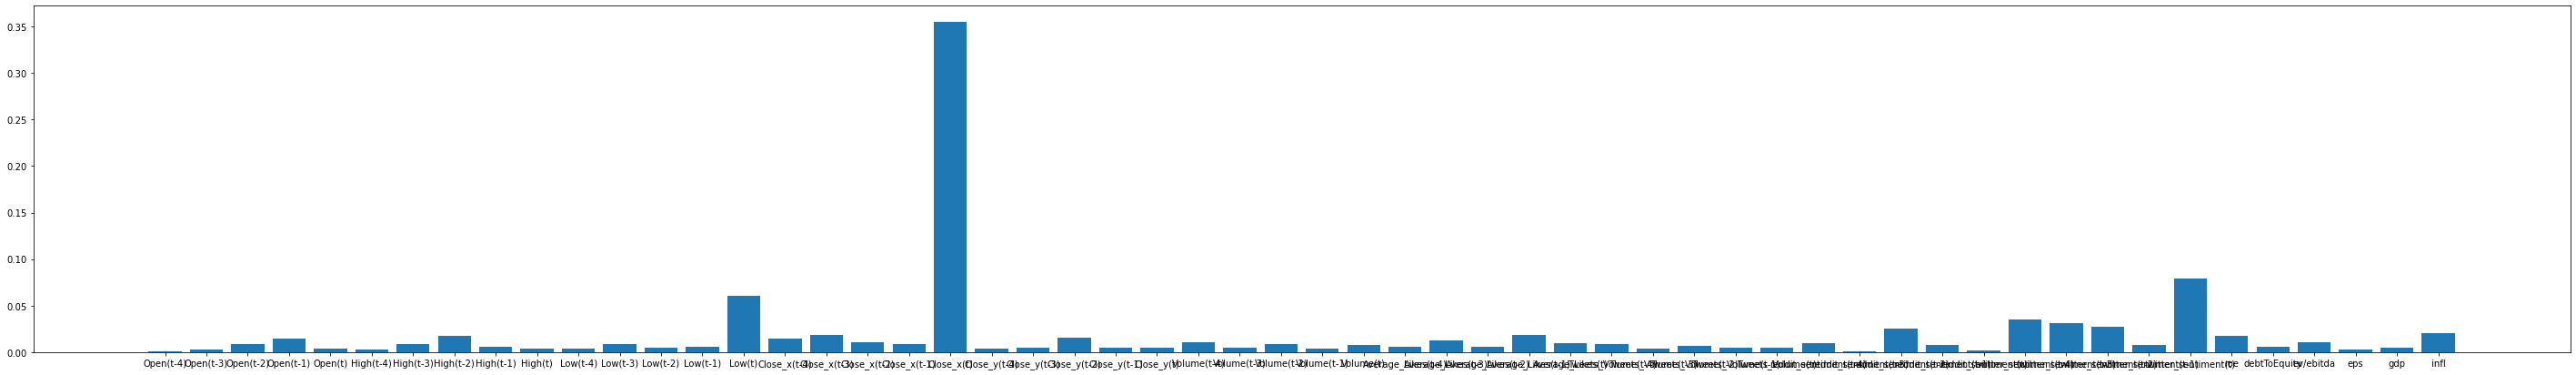

In [51]:
# get importance
importance = best_model.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
 print(f'Feature: {col_order[i]}, Score: {v:.10f}')
# plot feature importance
fig = plt.figure(figsize=(50,7))
plt.bar([col_order[x] for x in range(len(importance))], importance)
plt.show()

Feature: Open, Score: 0.0314181348
Feature: High, Score: 0.0386827954
Feature: Low, Score: 0.0834138466
Feature: Close_x, Score: 0.4063521193
Feature: Close_y, Score: 0.0334148345
Feature: Volume, Score: 0.0361604929
Feature: Average_Likes, Score: 0.0524111970
Feature: Tweets_Volume, Score: 0.0299807160
Feature: reddit_sentiment, Score: 0.0459027561
Feature: twitter_sentiment, Score: 0.1798912073
Feature: roe, Score: 0.0171085718
Feature: debtToEquity, Score: 0.0060480277
Feature: ev/ebitda, Score: 0.0105898106
Feature: eps, Score: 0.0032999974
Feature: gdp, Score: 0.0047432287
Feature: infl, Score: 0.0205822638


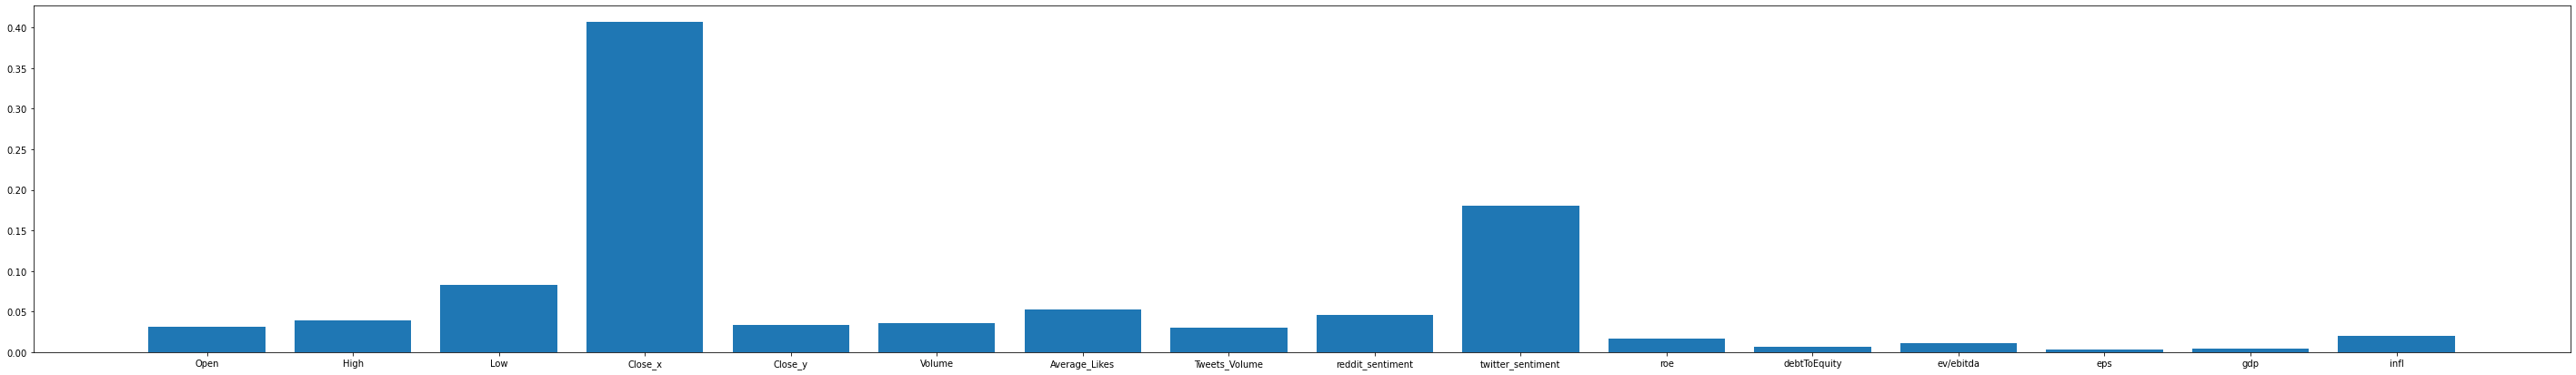

In [52]:
# get importance
importance = best_model.feature_importances_

cols = ['Open', 'High', 'Low', 'Close_x', 'Close_y', 'Volume', 'Average_Likes', 'Tweets_Volume','reddit_sentiment', 'twitter_sentiment','roe', 'debtToEquity','ev/ebitda', 'eps', 'gdp', 'infl']

agg_impt = []
cur = 0
cur_var = 'Open'
at = 0
for i,v in enumerate(importance):
    if (col_order[i].find(cur_var) > -1):
        cur += v
    else: 
        agg_impt.append(cur)
        print(f'Feature: {cols[at]}, Score: {cur:.10f}')
        at += 1
        cur_var = cols[at]
        cur = v
agg_impt.append(cur)
print(f'Feature: {cols[-1]}, Score: {cur:.10f}')
 
# plot feature importance
fig = plt.figure(figsize=(50,7))
plt.bar([cols[x] for x in range(len(cols))], agg_impt)
plt.show()

### XGBoost Regression Feature Importance

In [53]:
from xgboost import XGBRegressor

best_model = XGBRegressor()
best_model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [54]:
pred = best_model.predict(X_test)
pred_trformed = [pred[x - y_test.index[0]] * trform_list[x][3][0] + trform_list[x][3][1] for x in y_test.index]
y_trformed =  [y[x] * trform_list[x][3][0] + trform_list[x][3][1] for x in y_test.index]

mae = mean_absolute_error(y_trformed, pred_trformed)
mse = mean_squared_error(y_trformed, pred_trformed)
rmse = mean_squared_error(y_trformed, pred_trformed, squared=False)
r2 = r2_score(y_trformed, pred_trformed)
score_df.loc[len(score_df)] = ['past5_XGB', mae, mse, rmse]
    
print('Mean Absolute Error:', mae)
print('Mean Squared Error:', mse)
print('Root Mean Squared Error:', rmse)
print('R-squared:', r2)    

Mean Absolute Error: 8.38984323012263
Mean Squared Error: 110.72079933421386
Root Mean Squared Error: 10.522395132963496
R-squared: 0.29294083308963115


<AxesSubplot:>

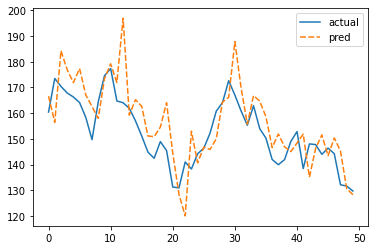

In [55]:
output = pd.DataFrame({'actual': np.array(y_trformed), 'pred': np.array(pred_trformed)})

sns.lineplot(data=output)

Feature: Open(t-4), Score: 0.0021076391
Feature: Open(t-3), Score: 0.0063995267
Feature: Open(t-2), Score: 0.0041082255
Feature: Open(t-1), Score: 0.0045832763
Feature: Open(t), Score: 0.0000223469
Feature: High(t-4), Score: 0.0147910593
Feature: High(t-3), Score: 0.0180325359
Feature: High(t-2), Score: 0.0198712144
Feature: High(t-1), Score: 0.0018402092
Feature: High(t), Score: 0.0000844266
Feature: Low(t-4), Score: 0.0012326164
Feature: Low(t-3), Score: 0.0202654712
Feature: Low(t-2), Score: 0.0142097436
Feature: Low(t-1), Score: 0.0021501170
Feature: Low(t), Score: 0.0434457287
Feature: Close_x(t-4), Score: 0.0296872985
Feature: Close_x(t-3), Score: 0.0028402952
Feature: Close_x(t-2), Score: 0.0054764892
Feature: Close_x(t-1), Score: 0.0001789518
Feature: Close_x(t), Score: 0.4647505581
Feature: Close_y(t-4), Score: 0.0005148578
Feature: Close_y(t-3), Score: 0.0053799977
Feature: Close_y(t-2), Score: 0.0298528839
Feature: Close_y(t-1), Score: 0.0050647566
Feature: Close_y(t), Score

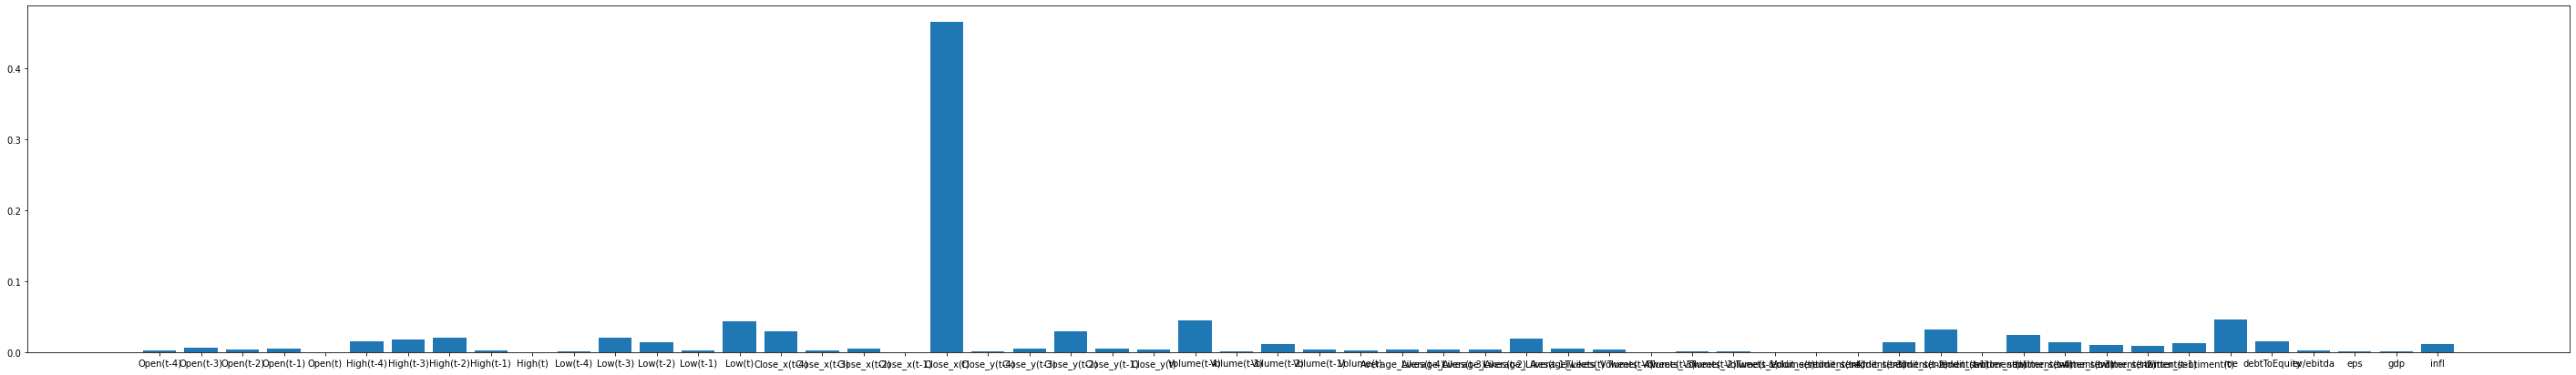

In [56]:
# get importance
importance = best_model.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
 print(f'Feature: {col_order[i]}, Score: {v:.10f}')
# plot feature importance
fig = plt.figure(figsize=(50,7))
plt.bar([col_order[x] for x in range(len(importance))], importance)
plt.show()

Feature: Open, Score: 0.0172210146
Feature: High, Score: 0.0546194464
Feature: Low, Score: 0.0813036785
Feature: Close_x, Score: 0.5029336214
Feature: Close_y, Score: 0.0442120470
Feature: Volume, Score: 0.0649188608
Feature: Average_Likes, Score: 0.0361175723
Feature: Tweets_Volume, Score: 0.0061660330
Feature: reddit_sentiment, Score: 0.0459830686
Feature: twitter_sentiment, Score: 0.0689307079
Feature: roe, Score: 0.0464090183
Feature: debtToEquity, Score: 0.0150823360
Feature: ev/ebitda, Score: 0.0022942927
Feature: eps, Score: 0.0013126661
Feature: gdp, Score: 0.0013768285
Feature: infl, Score: 0.0111187771


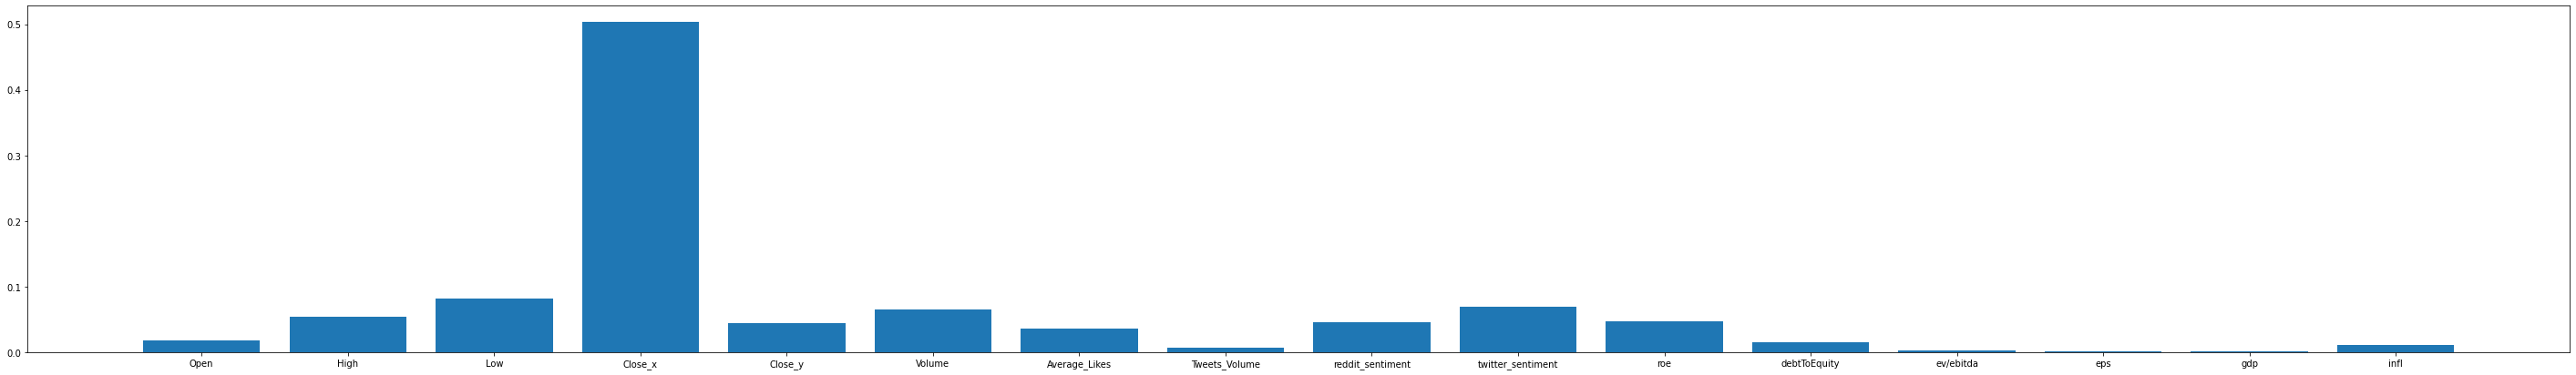

In [57]:
# get importance
importance = best_model.feature_importances_

cols = ['Open', 'High', 'Low', 'Close_x', 'Close_y', 'Volume','Average_Likes', 'Tweets_Volume', 'reddit_sentiment', 'twitter_sentiment','roe', 'debtToEquity','ev/ebitda', 'eps', 'gdp', 'infl']

agg_impt = []
cur = 0
cur_var = 'Open'
at = 0
for i,v in enumerate(importance):
    if (col_order[i].find(cur_var) > -1):
        cur += v
    else: 
        agg_impt.append(cur)
        print(f'Feature: {cols[at]}, Score: {cur:.10f}')
        at += 1
        cur_var = cols[at]
        cur = v
agg_impt.append(cur)
print(f'Feature: {cols[-1]}, Score: {cur:.10f}')
 
# plot feature importance
fig = plt.figure(figsize=(50,7))
plt.bar([cols[x] for x in range(len(cols))], agg_impt)
plt.show()

### Generate Training Data

In [58]:
train_df.columns

Index(['Open(t-4)', 'Open(t-3)', 'Open(t-2)', 'Open(t-1)', 'Open(t)',
       'High(t-4)', 'High(t-3)', 'High(t-2)', 'High(t-1)', 'High(t)',
       'Low(t-4)', 'Low(t-3)', 'Low(t-2)', 'Low(t-1)', 'Low(t)',
       'Close_x(t-4)', 'Close_x(t-3)', 'Close_x(t-2)', 'Close_x(t-1)',
       'Close_x(t)', 'Close_y(t-4)', 'Close_y(t-3)', 'Close_y(t-2)',
       'Close_y(t-1)', 'Close_y(t)', 'Volume(t-4)', 'Volume(t-3)',
       'Volume(t-2)', 'Volume(t-1)', 'Volume(t)', 'Average_Likes(t-4)',
       'Average_Likes(t-3)', 'Average_Likes(t-2)', 'Average_Likes(t-1)',
       'Average_Likes(t)', 'Tweets_Volume(t-4)', 'Tweets_Volume(t-3)',
       'Tweets_Volume(t-2)', 'Tweets_Volume(t-1)', 'Tweets_Volume(t)',
       'reddit_sentiment(t-4)', 'reddit_sentiment(t-3)',
       'reddit_sentiment(t-2)', 'reddit_sentiment(t-1)', 'reddit_sentiment(t)',
       'twitter_sentiment(t-4)', 'twitter_sentiment(t-3)',
       'twitter_sentiment(t-2)', 'twitter_sentiment(t-1)',
       'twitter_sentiment(t)', 'roe', 'debtToE

In [59]:
dropped_cols = ['debtToEquity', 'ev/ebitda', 'eps', 'gdp', 'index']

In [60]:
training_data = train_df.reset_index().drop(columns=dropped_cols, axis=1)

In [61]:
training_data.columns

Index(['Open(t-4)', 'Open(t-3)', 'Open(t-2)', 'Open(t-1)', 'Open(t)',
       'High(t-4)', 'High(t-3)', 'High(t-2)', 'High(t-1)', 'High(t)',
       'Low(t-4)', 'Low(t-3)', 'Low(t-2)', 'Low(t-1)', 'Low(t)',
       'Close_x(t-4)', 'Close_x(t-3)', 'Close_x(t-2)', 'Close_x(t-1)',
       'Close_x(t)', 'Close_y(t-4)', 'Close_y(t-3)', 'Close_y(t-2)',
       'Close_y(t-1)', 'Close_y(t)', 'Volume(t-4)', 'Volume(t-3)',
       'Volume(t-2)', 'Volume(t-1)', 'Volume(t)', 'Average_Likes(t-4)',
       'Average_Likes(t-3)', 'Average_Likes(t-2)', 'Average_Likes(t-1)',
       'Average_Likes(t)', 'Tweets_Volume(t-4)', 'Tweets_Volume(t-3)',
       'Tweets_Volume(t-2)', 'Tweets_Volume(t-1)', 'Tweets_Volume(t)',
       'reddit_sentiment(t-4)', 'reddit_sentiment(t-3)',
       'reddit_sentiment(t-2)', 'reddit_sentiment(t-1)', 'reddit_sentiment(t)',
       'twitter_sentiment(t-4)', 'twitter_sentiment(t-3)',
       'twitter_sentiment(t-2)', 'twitter_sentiment(t-1)',
       'twitter_sentiment(t)', 'roe', 'infl', 

In [62]:
training_data

,Open(t-4),Open(t-3),Open(t-2),Open(t-1),Open(t),High(t-4),High(t-3),High(t-2),High(t-1),High(t),...,reddit_sentiment(t-1),reddit_sentiment(t),twitter_sentiment(t-4),twitter_sentiment(t-3),twitter_sentiment(t-2),twitter_sentiment(t-1),twitter_sentiment(t),roe,infl,Close_x1(t+1)
0,37.644700,41.646481,41.157286,41.062921,42.030764,41.357371,42.299392,41.733146,42.553387,43.008279,...,0.000000,0.000000,0.127374,0.256366,0.244529,0.207746,0.318402,0.109210,0.190660,43.286526
1,41.646481,41.157286,41.062921,42.030764,42.570328,42.299392,41.733146,42.553387,43.008279,43.339757,...,0.000000,0.000000,0.256366,0.244529,0.207746,0.318402,0.206934,0.109210,0.237069,45.493195
2,41.157286,41.062921,42.030764,42.570328,43.552680,41.733146,42.553387,43.008279,43.339757,45.582718,...,0.000000,0.000000,0.244529,0.207746,0.318402,0.206934,0.247462,0.109210,0.283478,45.667412
3,41.062921,42.030764,42.570328,43.552680,45.573048,42.553387,43.008279,43.339757,45.582718,47.832947,...,0.000000,0.000000,0.207746,0.318402,0.206934,0.247462,0.230397,0.109210,0.329887,46.272312
4,42.030764,42.570328,43.552680,45.573048,46.373935,43.008279,43.339757,45.582718,47.832947,46.669125,...,0.000000,0.000000,0.318402,0.206934,0.247462,0.230397,0.148224,0.109210,0.376296,48.416073
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,149.613005,154.587129,140.195943,151.987936,147.904180,156.999459,154.955949,150.050891,153.355842,151.598536,...,0.000000,0.000000,0.170015,0.066024,0.093421,0.091963,0.043767,0.504836,0.367535,146.406464
196,154.587129,140.195943,151.987936,147.904180,144.070019,154.955949,150.050891,153.355842,151.598536,150.689917,...,0.000000,0.152096,0.066024,0.093421,0.091963,0.043767,0.068209,0.528813,0.304319,144.269730
197,140.195943,151.987936,147.904180,144.070019,146.845798,150.050891,153.355842,151.598536,150.689917,147.075443,...,0.152096,0.158785,0.093421,0.091963,0.043767,0.068209,0.222123,0.528813,0.202989,132.168198
198,151.987936,147.904180,144.070019,146.845798,149.272088,153.355842,151.598536,150.689917,147.075443,149.741373,...,0.158785,0.000000,0.091963,0.043767,0.068209,0.222123,0.105450,0.528813,0.101658,131.658981


In [63]:
training_data.to_csv('training_data.csv', index=False)

### Generate 4 output training_data

In [135]:
final_data = data.copy().drop(columns=['Date', 'dateStr'])
training_data1 = series_to_supervised(final_data, 'Close_x',['roe', 'debtToEquity', 'ev/ebitda', 'eps', 'gdp', 'infl'], 8, 4)

In [136]:
cols_series = ['Open', 'High', 'Low', 'Close_x', 'Close_y', 'Volume', 'reddit_sentiment', 'twitter_sentiment']
cols_unival = ['roe', 'infl', 'Close_x1(t+1)', 'Close_x1(t+2)', 'Close_x1(t+3)','Close_x1(t+4)']

In [137]:
col_order = []
cur = pd.Series(training_data1.columns)

for col in cols_series:
    filtered = list(cur[cur.str.startswith(col)])
    if (col == 'Close_x'):
        filtered = [x for x in filtered if x.startswith('Close_x1') == False]
    col_order.extend(filtered)

col_order.extend(cols_unival)

In [138]:
training_data1 = training_data1[col_order]

In [139]:
training_data1.columns

Index(['Open(t-7)', 'Open(t-6)', 'Open(t-5)', 'Open(t-4)', 'Open(t-3)',
       'Open(t-2)', 'Open(t-1)', 'Open(t)', 'High(t-7)', 'High(t-6)',
       'High(t-5)', 'High(t-4)', 'High(t-3)', 'High(t-2)', 'High(t-1)',
       'High(t)', 'Low(t-7)', 'Low(t-6)', 'Low(t-5)', 'Low(t-4)', 'Low(t-3)',
       'Low(t-2)', 'Low(t-1)', 'Low(t)', 'Close_x(t-7)', 'Close_x(t-6)',
       'Close_x(t-5)', 'Close_x(t-4)', 'Close_x(t-3)', 'Close_x(t-2)',
       'Close_x(t-1)', 'Close_x(t)', 'Close_y(t-7)', 'Close_y(t-6)',
       'Close_y(t-5)', 'Close_y(t-4)', 'Close_y(t-3)', 'Close_y(t-2)',
       'Close_y(t-1)', 'Close_y(t)', 'Volume(t-7)', 'Volume(t-6)',
       'Volume(t-5)', 'Volume(t-4)', 'Volume(t-3)', 'Volume(t-2)',
       'Volume(t-1)', 'Volume(t)', 'reddit_sentiment(t-7)',
       'reddit_sentiment(t-6)', 'reddit_sentiment(t-5)',
       'reddit_sentiment(t-4)', 'reddit_sentiment(t-3)',
       'reddit_sentiment(t-2)', 'reddit_sentiment(t-1)', 'reddit_sentiment(t)',
       'twitter_sentiment(t-7)', 'tw

In [141]:
training_data1.to_csv('training_data1.csv')

## Sentiment Only

In [64]:
data.columns

Index(['Date', 'Open', 'High', 'Low', 'Close_x', 'Volume', 'Close_y', 'roe',
       'debtToEquity', 'ev/ebitda', 'eps', 'gdp', 'infl', 'dateStr',
       'reddit_sentiment', 'twitter_sentiment', 'Tweets_Volume',
       'Average_Likes'],
      dtype='object')

In [65]:
final_data = data.copy()[['Close_x','reddit_sentiment', 'twitter_sentiment']]
train_df = series_to_supervised(final_data, 'Close_x',[], 5, 1)

In [66]:
train_df['change'] = train_df['Close_x1(t+1)'] - train_df['Close_x(t)']

In [67]:
x = train_df.drop(columns=['Close_x1(t+1)', 'change','Close_x(t)', 'Close_x(t-4)', 'Close_x(t-3)', 'Close_x(t-2)', 'Close_x(t-1)'], axis=1)
y = train_df['change']

In [68]:
# Take last 50 days as test data
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=88, shuffle=False)

In [69]:
X_train, y_train = shuffle(X_train, y_train, random_state=0)

In [70]:
from sklearn.linear_model import LinearRegression

best_model = LinearRegression().fit(X_train, y_train)

In [71]:
pred = best_model.predict(X_test)
outcome_df = train_df.iloc[153:].copy()
outcome_df['outcome'] = outcome_df['Close_x(t)'] + pred

mae = mean_absolute_error(outcome_df['Close_x1(t+1)'], outcome_df['outcome'])
mse = mean_squared_error(outcome_df['Close_x1(t+1)'],  outcome_df['outcome'])
rmse = mean_squared_error(outcome_df['Close_x1(t+1)'],  outcome_df['outcome'], squared=False)
r2 = r2_score(outcome_df['Close_x1(t+1)'], outcome_df['outcome'])
score_df.loc[len(score_df)] = ['sentiment', mae, mse, rmse]
    
print('Mean Absolute Error:', mae)
print('Mean Squared Error:', mse)
print('Root Mean Squared Error:', rmse)
print('R-squared:', r2)    

Mean Absolute Error: 6.022058387681421
Mean Squared Error: 53.78829572524553
Root Mean Squared Error: 7.334050431054148
R-squared: 0.6651654097008549


<AxesSubplot:>

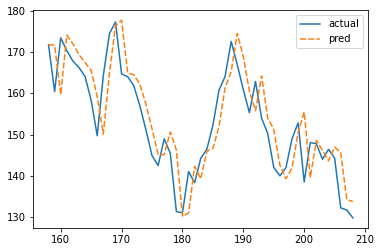

In [72]:
output = pd.DataFrame({'actual': outcome_df['Close_x1(t+1)'], 'pred': outcome_df['outcome']})
sns.lineplot(data=output)

Feature: reddit_sentiment(t-4), Score: -4.581945605863427140036492346553
Feature: twitter_sentiment(t-4), Score: -6.521794344590997383193098357879
Feature: reddit_sentiment(t-3), Score: 1.030335989868863988405678355775
Feature: twitter_sentiment(t-3), Score: -4.630324603743357414487036294304
Feature: reddit_sentiment(t-2), Score: 2.262371784344112235487500583986
Feature: twitter_sentiment(t-2), Score: 3.770999812368116543837004428497
Feature: reddit_sentiment(t-1), Score: 1.629189357750540745328748926113
Feature: twitter_sentiment(t-1), Score: 3.954373725508026460317978489911
Feature: reddit_sentiment(t), Score: 0.420432245314098729238594387425
Feature: twitter_sentiment(t), Score: 4.802758973054434221694464213215


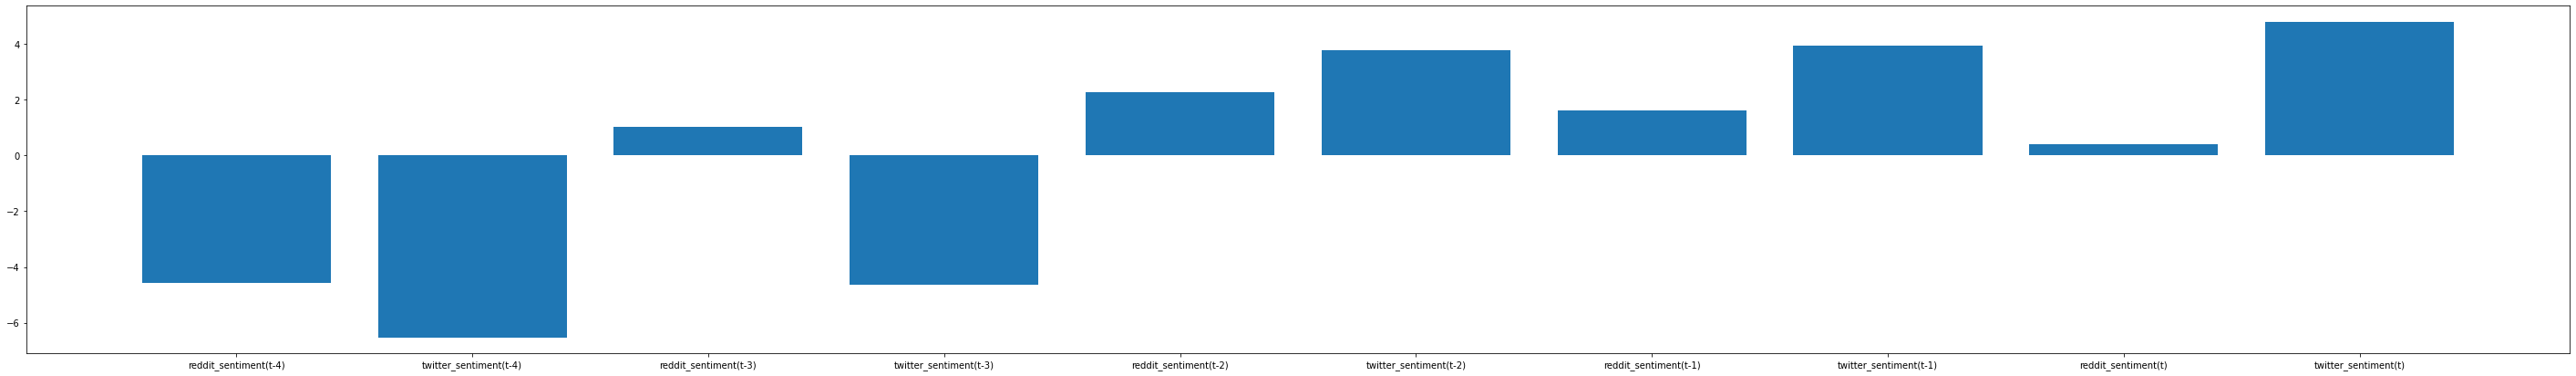

In [73]:
# get importance
importance = best_model.coef_
# summarize feature importance
for i,v in enumerate(importance):
 print(f'Feature: {X_train.columns[i]}, Score: {v:.30f}')
# plot feature importance
fig = plt.figure(figsize=(50,7))
plt.bar([X_train.columns[y] for y in range(len(importance))], importance)
plt.show()

### Price + Sentiment

In [74]:
final_data = data.copy()[['Close_x', 'Close_y' ,'reddit_sentiment', 'twitter_sentiment']]
train_df = series_to_supervised(final_data, 'Close_x',[], 5, 1)

In [75]:
train_df.columns

Index(['Close_x(t-4)', 'Close_y(t-4)', 'reddit_sentiment(t-4)',
       'twitter_sentiment(t-4)', 'Close_x(t-3)', 'Close_y(t-3)',
       'reddit_sentiment(t-3)', 'twitter_sentiment(t-3)', 'Close_x(t-2)',
       'Close_y(t-2)', 'reddit_sentiment(t-2)', 'twitter_sentiment(t-2)',
       'Close_x(t-1)', 'Close_y(t-1)', 'reddit_sentiment(t-1)',
       'twitter_sentiment(t-1)', 'Close_x(t)', 'Close_y(t)',
       'reddit_sentiment(t)', 'twitter_sentiment(t)', 'Close_x1(t+1)'],
      dtype='object')

In [76]:
cols_series = ['Close_x', 'Close_y', 'reddit_sentiment', 'twitter_sentiment']
cols_unival = ['Close_x1(t+1)']

In [77]:
col_order = []
cur = pd.Series(train_df.columns)

for col in cols_series:
    filtered = list(cur[cur.str.startswith(col)])
    if (col == 'Close_x'):
        filtered.remove('Close_x1(t+1)')
    col_order.extend(filtered)

col_order.extend(cols_unival)

In [78]:
train_df = train_df[col_order]

In [79]:
train_scaled = train_df.copy()
train_scaled = train_scaled.reset_index().drop('index', axis=1)

In [80]:
trform_list = {}

In [81]:
def minmaxscalerAdjust(index, row, in_size, num_var, position):
    trform_dict = {}
    trformed_row = []
    value = 0
    for i in range(num_var):
        cur = np.array(row[ i*in_size : (i+1)*in_size ])
        rowmaxmin = cur.max() - cur.min()
        print('rowmaxmin', rowmaxmin)
        rowmin = cur.min()
        print('rowmin', rowmin)
        trform_dict[i] = [rowmaxmin, rowmin]
        trform_list[index] = trform_dict
        cur = [ (x - rowmin) / (rowmaxmin) for x in cur]
        trformed_row.extend(cur)
        if (i == position):
            target = row[-1]
            value = (target - rowmin) / rowmaxmin
    
    rest = np.array(row[ num_var*in_size : -1 ])
    trformed_row.extend(rest)
    trformed_row.append(value)
    return trformed_row

In [82]:
for index, row in train_scaled.iterrows():
    trformed_row = minmaxscalerAdjust(index, row, 5, 2,0)
    train_scaled.loc[index] = trformed_row

rowmaxmin 5.618389129638665
rowmin 35.64020156860352
rowmaxmin 175.18017578125
rowmin 2549.68994140625
rowmaxmin 5.119667053222656
rowmin 36.13892364501953
rowmaxmin 142.260009765625
rowmin 2582.610107421875
rowmaxmin 3.601837158203125
rowmin 37.65675354003906
rowmaxmin 131.75
rowmin 2643.85009765625
rowmaxmin 4.499820709228516
rowmin 37.65675354003906
rowmaxmin 152.260009765625
rowmin 2643.85009765625
rowmaxmin 1.72845458984375
rowmin 40.82010269165039
rowmaxmin 86.31005859375
rowmin 2709.800048828125
rowmaxmin 2.4664230346679688
rowmin 40.82010269165039
rowmaxmin 86.31005859375
rowmin 2709.800048828125
rowmaxmin 4.25848388671875
rowmin 41.234710693359375
rowmaxmin 57.33984375
rowmin 2775.60009765625
rowmaxmin 3.5108375549316406
rowmin 42.15657424926758
rowmaxmin 49.639892578125
rowmin 2783.300048828125
rowmaxmin 3.7237548828125
rowmin 42.54855728149414
rowmaxmin 83.889892578125
rowmin 2783.300048828125
rowmaxmin 5.129547119140618
rowmin 43.28652572631836
rowmaxmin 112.469970703125
ro

rowmin 4387.16015625
rowmaxmin 8.354995727539062
rowmin 144.59756469726562
rowmaxmin 103.080078125
rowmin 4432.35009765625
rowmaxmin 4.708526611328125
rowmin 148.24403381347656
rowmaxmin 66.7001953125
rowmin 4468.72998046875
rowmaxmin 11.260818481445312
rowmin 141.69174194335938
rowmaxmin 177.7001953125
rowmin 4357.72998046875
rowmaxmin 11.260818481445312
rowmin 141.69174194335938
rowmaxmin 177.7001953125
rowmin 4357.72998046875
rowmaxmin 15.02764892578125
rowmin 137.92491149902344
rowmaxmin 234.97021484375
rowmin 4300.4599609375
rowmaxmin 10.319122314453125
rowmin 137.92491149902344
rowmaxmin 168.27001953125
rowmin 4300.4599609375
rowmaxmin 7.3453216552734375
rowmin 137.92491149902344
rowmaxmin 186.0
rowmin 4300.4599609375
rowmaxmin 9.41705322265625
rowmin 137.92491149902344
rowmaxmin 266.02001953125
rowmin 4300.4599609375
rowmaxmin 9.7342529296875
rowmin 137.92491149902344
rowmaxmin 313.2099609375
rowmin 4300.4599609375
rowmaxmin 7.563385009765625
rowmin 141.5628662109375
rowmaxmin 3

In [83]:
x = train_scaled.drop('Close_x1(t+1)', axis=1)
y = train_scaled['Close_x1(t+1)']

In [84]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=88, shuffle=False)

In [85]:
X_train, y_train = shuffle(X_train, y_train, random_state=0)

In [86]:
from sklearn.linear_model import LinearRegression

best_model = LinearRegression().fit(X_train, y_train)

In [87]:
pred = best_model.predict(X_test)
pred_trformed = [pred[x - y_test.index[0]] * trform_list[x][0][0] + trform_list[x][0][1] for x in y_test.index]
y_trformed =  [y[x] * trform_list[x][0][0] + trform_list[x][0][1] for x in y_test.index]

mae = mean_absolute_error(y_trformed, pred_trformed)
mse = mean_squared_error(y_trformed, pred_trformed)
rmse = mean_squared_error(y_trformed, pred_trformed, squared=False)
r2 = r2_score(y_trformed, pred_trformed)
score_df.loc[len(score_df)] = ['price+sentiment_LR', mae, mse, rmse]
    
print('Mean Absolute Error:', mae)
print('Mean Squared Error:', mse)
print('Root Mean Squared Error:', rmse)
print('R-squared:', r2)    

Mean Absolute Error: 7.370917045007307
Mean Squared Error: 71.99985481154631
Root Mean Squared Error: 8.485272818922578
R-squared: 0.5517976250713047


<AxesSubplot:>

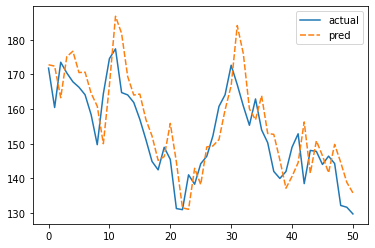

In [88]:
output = pd.DataFrame({'actual': np.array(y_trformed), 'pred': np.array(pred_trformed)})

sns.lineplot(data=output)

In [89]:
score_df

,vars,mae,mse,rmse
0,past10_LR,12.611757,253.105419,15.909287
1,past5_LR,7.990322,88.882584,9.427756
2,past5_RF,7.440569,79.043744,8.890655
3,past5_XGB,8.389843,110.720799,10.522395
4,sentiment,6.022058,53.788296,7.334050
5,price+sentiment_LR,7.370917,71.999855,8.485273


In [90]:
# # get importance
# importance = best_model.coef_

# cols = [ 'Close_x', 'Close_y','reddit_sentiment', 'twitter_sentiment']

# agg_impt = []
# cur = 0
# cur_var = 'Open'
# at = 0
# for i,v in enumerate(importance):
#     if (col_order[i].find(cur_var) > -1):
#         cur += v
#     else: 
#         agg_impt.append(cur)
#         print(f'Feature: {cols[at]}, Score: {cur:.10f}')
#         at += 1
#         cur_var = cols[at]
#         cur = v
# agg_impt.append(cur)
# print(f'Feature: {cols[-1]}, Score: {cur:.10f}')
 
# # plot feature importance
# fig = plt.figure(figsize=(50,7))
# plt.bar([cols[x] for x in range(len(cols))], agg_impt)
# plt.show()

## Extra EDA

In [91]:
final_data = data.copy()[['Close_x', 'Close_y' ,'reddit_sentiment', 'twitter_sentiment']]
train_eda = series_to_supervised(final_data, 'Close_x',[], 5, 1).reset_index()

In [92]:
from sklearn.preprocessing import MinMaxScaler

scalerPrice = MinMaxScaler()
scalerSentimentT = MinMaxScaler()
scalerSentimentR = MinMaxScaler()
scalerIndexPrice = MinMaxScaler()

In [93]:
train_eda.columns

Index(['index', 'Close_x(t-4)', 'Close_y(t-4)', 'reddit_sentiment(t-4)',
       'twitter_sentiment(t-4)', 'Close_x(t-3)', 'Close_y(t-3)',
       'reddit_sentiment(t-3)', 'twitter_sentiment(t-3)', 'Close_x(t-2)',
       'Close_y(t-2)', 'reddit_sentiment(t-2)', 'twitter_sentiment(t-2)',
       'Close_x(t-1)', 'Close_y(t-1)', 'reddit_sentiment(t-1)',
       'twitter_sentiment(t-1)', 'Close_x(t)', 'Close_y(t)',
       'reddit_sentiment(t)', 'twitter_sentiment(t)', 'Close_x1(t+1)'],
      dtype='object')

In [94]:
train_eda.loc[0, 'price_wo_seasonality' ] = 0
train_eda.loc[0, 'iprice_wo_seasonality'] = 0
for index, row in train_eda.iloc[1:].iterrows():
    train_eda.loc[index,'price_wo_seasonality'] = train_eda.loc[index, 'Close_x(t)'] - train_eda.loc[index-1, 'Close_x(t)']
    train_eda.loc[index,'iprice_wo_seasonality'] = train_eda.loc[index, 'Close_y(t)'] - train_eda.loc[index-1, 'Close_y(t)']

In [95]:
train_eda['price_wo_seasonality'] = [x[0] for x in scalerPrice.fit_transform(np.array(train_eda['price_wo_seasonality']).reshape(-1,1))]

In [96]:
train_eda['iprice_wo_seasonality'] = [x[0] for x in scalerPrice.fit_transform(np.array(train_eda['iprice_wo_seasonality']).reshape(-1,1))]

In [97]:
train_eda['twitter_sentiment(t)'] = [x[0] for x in scalerSentimentT.fit_transform(np.array(train_eda['twitter_sentiment(t)']).reshape(-1,1))]

In [98]:
train_eda['reddit_sentiment(t)'] = [x[0] for x in scalerSentimentR.fit_transform(np.array(train_eda['reddit_sentiment(t)']).reshape(-1,1))]

<AxesSubplot:>

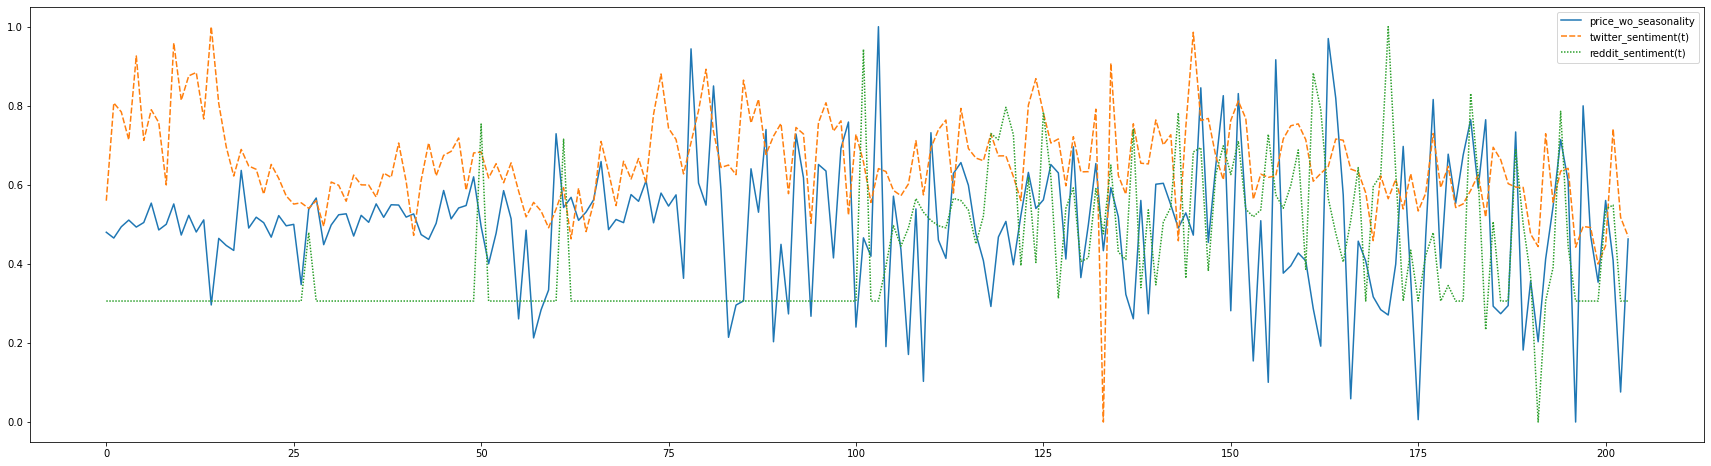

In [99]:
fig = plt.figure(figsize=(30, 8))
sns.lineplot(data=train_eda[['price_wo_seasonality','twitter_sentiment(t)', 'reddit_sentiment(t)']])

<AxesSubplot:>

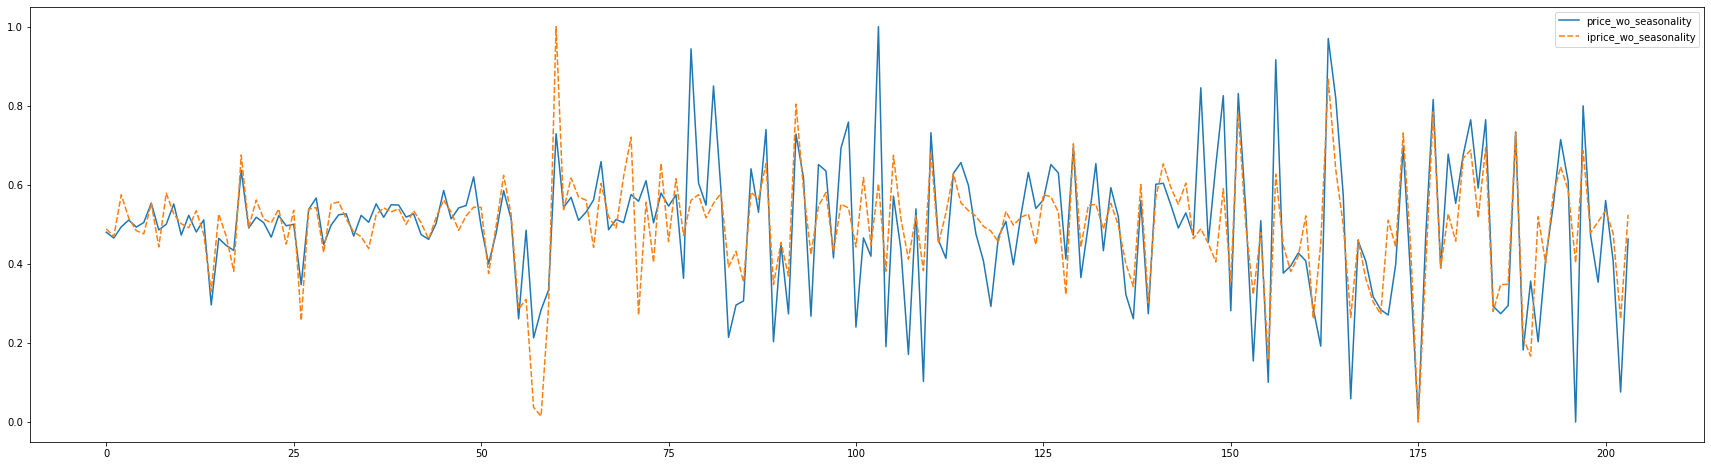

In [100]:
fig = plt.figure(figsize=(30, 8))
sns.lineplot(data=train_eda[['price_wo_seasonality','iprice_wo_seasonality']])